# Neonatal vaccination to reduce prevalence of an endemic disease in livestock

This week, you have learned about how different susceptibility-shaping mechanisms can have a big impact on disease dynamics. In this exercise, your task is to bring these mechanisms - population turnover, vaccination and waning immunity - together to investigate a public health question. By now hopefully you will be familiar with the general approach used, to simulate a model in R. This etivity is less structured, so it allows you to independently practice what you have learnt over the whole course so far. Here are the instructions:

A neonatal vaccine has recently become available against an endemic viral infection in livestock. The Ministry of Agriculture has asked you to model the impact of different vaccination scenarios to inform the design of a farm animal vaccination programme. They provide you with the following information:
- The infection rate of the disease in this population is 1 day$^{-1}$ and the average duration of the infectious period is 20 days. 
- The average lifespan of the population is 3 years.
- The total population size in the country is 300000 and has not varied over time. The disease is endemic but thought to be relatively rare in this population.
- The vaccine, which has perfect efficacy, is given to a proportion *p_vacc* of newborn animals (that is, it is a neonatal vaccine). It is currently not known whether immunity to the disease and to the vaccine is life-long or wanes over time.

They want you to run the model to endemic equilibrum to answer the questions below.

**Tip:** It might be helpful to first read all the questions and think about what kind of model structure and parameters you need to be able to answer them all, and draw a diagram of the model structure before coding it. You have covered all these principles separately in the course so far, so if you struggle with a specific aspect you might want to look back at previous etivities. But don't worry - the etivity is designed to be challenging and get you thinking about how to develop and use a model to answer a specific research question!

In [5]:
# Modelling the epidemic

# LOAD THE PACKAGES:
library(deSolve)
library(reshape2)
library(ggplot2)

# MODEL INPUTS:

pop <- 300000

initial_state_values <- c(S = 0.48 * pop,
                          I = 0.04 * pop,
                          R = 0.48 * pop)
parameters <- c(beta = 1 * 365, gamma = 1/20 * 365, mu = 1/3, b = 1/3, p_vacc = 0, sigma = 0)

# TIMESTEPS:

times <- seq(from = 0, to = 3, by = 1/365)

sir_model <- function(time, state, parameters) {  
    
    with(as.list(c(state, parameters)), {     
      
        N <- S+I+R
        lambda <- beta * I/N
        dS <- -lambda * S- mu * S + (1-p_vacc) * b * N + sigma * R
        dI <- lambda * S - gamma * I  - mu * I
        dR <- gamma * I - mu * R  + p_vacc * b * N - sigma * R 
    
        return(list(c(dS, dI, dR))) 
    })
  
}

# MODEL OUTPUT (solving the differential equations):

output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters))

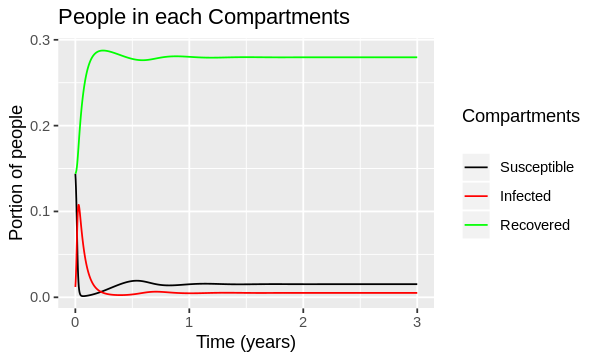

In [6]:
output_long <- melt(as.data.frame(output), id = "time")                  

options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(data = output_long,          # specify object containing data to plot
       aes(x = time, y = value / 1e6, group = variable, colour = variable)) +   # assign columns to axes and groups
  geom_line() +                     # represent data as lines
  labs(title = "People in each Compartments", x = "Time (years)", y = "Portion of people", color = "Compartments\n") +
  scale_color_manual(labels = c("Susceptible", "Infected", "Recovered"), values = c("black", "red", "green"))

### What is the endemic prevalence of the disease currently (the baseline prevalence), assuming permanent immunity?

- The baseline prevalence is 1.7%.
- The state values at equilibrium: $S$ = 15k , $I$ = 5k , $R$ = 280k

In [16]:
print(paste(output_long$value[round(output_long$time,0) == 3 & output_long$variable == "I"][1]/pop * 100, "%"))

output[output$time == 3,]

[1] "1.70325703386832 %"


,time,S,I,R
1096,3,15275.21,5106.915,279617.9


### What proportion of newborn animals would you need to vaccinate to reduce the prevalence by half, assuming life-long immunity?

- Assuming life-long immunity, we need to vaccinate around 48% of all newborns to achieve a reduction of the endemic prevalence to 0.85% from 1.7%.

In [69]:
initial_state_values <- c(S = 15 * 1e3,
                          I = 5 * 1e3,
                          R = 280 * 1e3)

parameters <- c(beta = 1 * 365, gamma = 1/20 * 365, mu = 1/3, b = 1/3, p_vacc = 0.48, sigma = 0)

output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters))

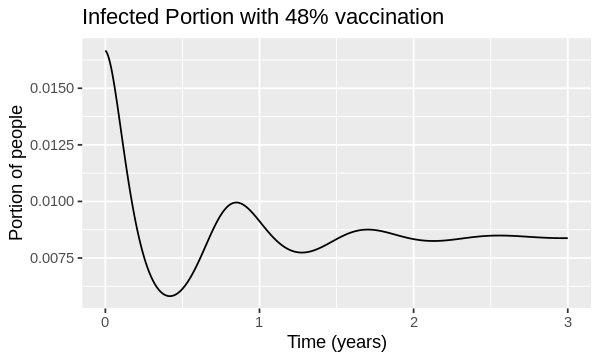

In [70]:
output_long <- melt(as.data.frame(output), id = "time")                  

options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(data = output,          # specify object containing data to plot
       aes(x = time, y = output$I / pop)) +   # assign columns to axes and groups
  geom_line() +                     # represent data as lines
  labs(title = "Infected Portion with 48% vaccination", x = "Time (years)", y = "Portion of people", color = "Compartments\n") +
  scale_color_manual(labels = c("Infected"), values = c("red"))

In [71]:
paste(output_long$value[round(output_long$time,0) == 3 & output_long$variable == "I"][1]/pop * 100, "%")

[1] "0.848582400049914 %"

### Would it be possible to eliminate the disease from the population using neonatal vaccination under the assumption of lifelong immunity?

- With a vaccine coverage of 91% or higher, yes. The disease dies out after three years.

In [89]:
parameters <- c(beta = 1 * 365, gamma = 1/20 * 365, mu = 1/3, b = 1/3, p_vacc = 0.91, sigma = 0)

output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters))

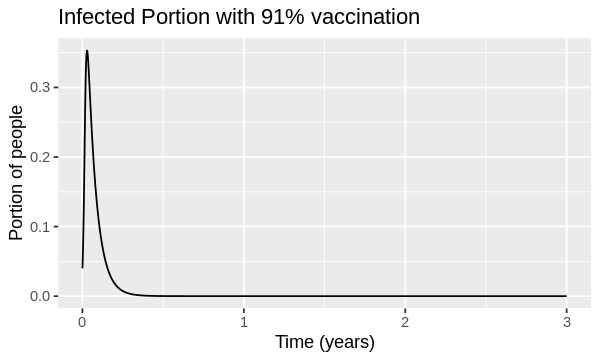

In [90]:
output_long <- melt(as.data.frame(output), id = "time")                  

options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(data = output,          # specify object containing data to plot
       aes(x = time, y = output$I / pop)) +   # assign columns to axes and groups
  geom_line() +                     # represent data as lines
  labs(title = "Infected Portion with 91% vaccination", x = "Time (years)", y = "Portion of people", color = "Compartments\n") +
  scale_color_manual(labels = c("Infected"), values = c("red"))

In [66]:
paste(output[round(output$time,0) == 3,"I"][1], "animals")

[1] "0.681987930008596 animals"

### If the average duration of immunity is only 1 year, how would this impact the proportional reduction in the prevalence with the vaccine coverage you obtained above compared to the baseline? 

- The 48% vaccine coverage leads to a 12.64% reduction in disease prevalence instead of 50%.

In [72]:
initial_state_values <- c(S = 0.48 * pop,
                          I = 0.04 * pop,
                          R = 0.48 * pop)
parameters <- c(beta = 1 * 365, gamma = 1/20 * 365, mu = 1/3, b = 1/3, p_vacc = 0, sigma = 1)

output_base <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters))

parameters <- c(beta = 1 * 365, gamma = 1/20 * 365, mu = 1/3, b = 1/3, p_vacc = 0.48, sigma = 1)

output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters))

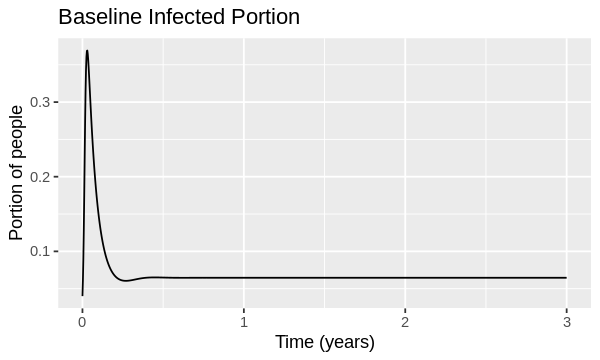

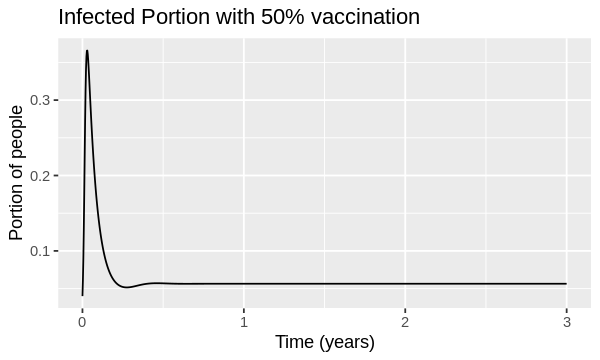

In [73]:
options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(data = output_base,          # specify object containing data to plot
       aes(x = time, y = output_base$I / pop)) +   # assign columns to axes and groups
  geom_line() +                     # represent data as lines
  labs(title = "Baseline Infected Portion", x = "Time (years)", y = "Portion of people", color = "Compartments\n") +
  scale_color_manual(labels = c("Infected"), values = c("red"))

options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(data = output,          # specify object containing data to plot
       aes(x = time, y = output$I / pop)) +   # assign columns to axes and groups
  geom_line() +                     # represent data as lines
  labs(title = "Infected Portion with 50% vaccination", x = "Time (years)", y = "Portion of people", color = "Compartments\n") +
  scale_color_manual(labels = c("Infected"), values = c("red"))

In [87]:
baseline_p <- output_base[round(output_base$time,0) == 3,"I"][1]
paste("baseline prevalence:  ", baseline_p/pop * 100, "%")

vacc_p <- output[round(output$time,0) == 3,"I"][1]
paste("vacc prevalence:        ", vacc_p/pop * 100, "%")

paste("prevalence reduction:", (1 - vacc_p/baseline_p) * 100, "%")

[1] "baseline prevalence:   6.46186728844811 %"

[1] "vacc prevalence:         5.64484601184985 %"

[1] "prevalence reduction: 12.6437334616706 %"

### Would it be possible to eliminate the disease from the population using neonatal vaccination under these assumptions?

- No, even with 100% vaccination we can not eliminate disease.

In [91]:
parameters <- c(beta = 1 * 365, gamma = 1/20 * 365, mu = 1/3, b = 1/3, p_vacc = 1, sigma = 1)

output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters))

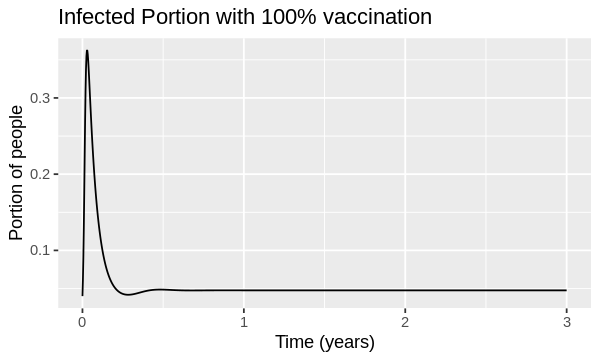

In [92]:
output_long <- melt(as.data.frame(output), id = "time")                  

options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(data = output,          # specify object containing data to plot
       aes(x = time, y = output$I / pop)) +   # assign columns to axes and groups
  geom_line() +                     # represent data as lines
  labs(title = "Infected Portion with 100% vaccination", x = "Time (years)", y = "Portion of people", color = "Compartments\n") +
  scale_color_manual(labels = c("Infected"), values = c("red"))

In [93]:
paste(output[round(output$time,0) == 3,"I"][1], "animals")

[1] "14279.2188883931 animals"

### If an adjuvant (a vaccine promoter) was given along with the vaccine, that would extend the duration of immunity to 2.5 years on average, what vaccine coverage would be needed to reduce the baseline prevalence by half? Would it be possible to eliminate the disease from the population under these assumptions using neonatal vaccination?

- With 100% vaccination, the baseline prevalence will reduced by 47.89% (not half!), from 3.67% to 1.91%. So, no, it is not possible to eliminate the disease.

In [94]:
parameters <- c(beta = 1 * 365, gamma = 1/20 * 365, mu = 1/3, b = 1/3, p_vacc = 0, sigma = 1/2.5)

output_base <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters))

parameters <- c(beta = 1 * 365, gamma = 1/20 * 365, mu = 1/3, b = 1/3, p_vacc = 1, sigma = 1/2.5)

output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters))

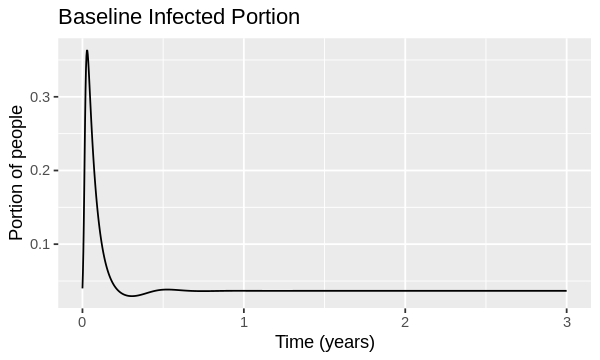

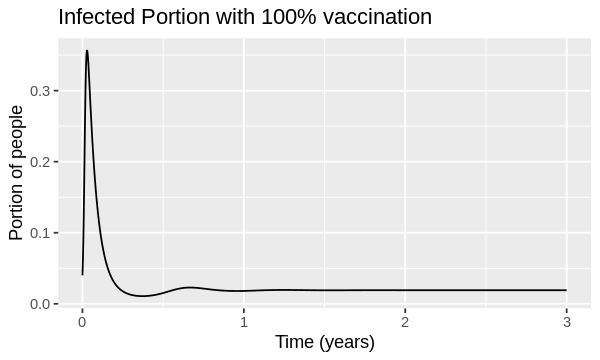

In [95]:
options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(data = output_base,          # specify object containing data to plot
       aes(x = time, y = output_base$I / pop)) +   # assign columns to axes and groups
  geom_line() +                     # represent data as lines
  labs(title = "Baseline Infected Portion", x = "Time (years)", y = "Portion of people", color = "Compartments\n") +
  scale_color_manual(labels = c("Infected"), values = c("red"))

options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(data = output,          # specify object containing data to plot
       aes(x = time, y = output$I / pop)) +   # assign columns to axes and groups
  geom_line() +                     # represent data as lines
  labs(title = "Infected Portion with 100% vaccination", x = "Time (years)", y = "Portion of people", color = "Compartments\n") +
  scale_color_manual(labels = c("Infected"), values = c("red"))

In [96]:
baseline_p <- output_base[round(output_base$time,0) == 3,"I"][1]
paste("baseline prevalence:  ", baseline_p/pop * 100, "%")

vacc_p <- output[round(output$time,0) == 3,"I"][1]
paste("vacc prevalence:        ", vacc_p/pop * 100, "%")

paste("prevalence reduction:", (1 - vacc_p/baseline_p) * 100, "%")

[1] "baseline prevalence:   3.66635783995341 %"

[1] "vacc prevalence:         1.91066941416385 %"

[1] "prevalence reduction: 47.8864448706368 %"

### Based on your results, what overall recommendation would you give to the Minister?

- Results about current prevalence and the impact of infant vaccination are not conclusive until more knowledge is available about the persistence of immunity. He could consider investing in further research in this area. If infant vaccination is performed and immunity declines rapidly, the addition of an adjuvant can improve the effectiveness of vaccination.

### Also provide some information to help the Minister interpret these results. Write down the assumptions in your modelling approach that you think might affect your results. Are there any adaptations you could make to the model structure that would make it more realistic or that would allow you to answer more detailed questions?

The results have shown that the conclusion depends on the assumptions we made about the amount of safety reduction. Other assumptions that may affect our results include:

* Vaccination is applied to a proportion p_vacc of births at every timestep, not to all newborns
* We assume that vaccine-induced immunity and immunity resulting from recovery from natural infection provide the same protection and decrease simultaneously.
* We assume that transmission is independent of age mixing, but the vaccine is only administered to infants, so its effect may vary depending on the speed of transmission and incidence in different age groups.

**Of course, check your answers against those in the "Solutions" folder!**